In [2]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob 
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from itertools import chain
from sklearn.model_selection import train_test_split, GroupShuffleSplit
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms as trans

In [57]:
ImageNet_norm = trans.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
ImageNet_trans = {'train':
    trans.Compose([
        trans.RandomResizedCrop(224),
        trans.RandomHorizontalFlip(),
        trans.ToTensor(),
        ImageNet_norm,
    ]),
    'test':
    trans.Compose([
        trans.Resize(256),
        trans.TenCrop(224),
        trans.Lambda(lambda crops: torch.stack([trans.ToTensor()(crop) for crop in crops])),
        trans.Lambda(lambda crops: torch.stack([ImageNet_norm(crop) for crop in crops]))
    ])
}

# NIH

To get NIH, you can simple use kaggle:

<b><i> kaggle dataset download nih-chest-xrays/data

In [64]:
class NIH(Dataset):
    def __init__(self, table, transform=None):
        self.og_idices = table.index.values
        self.image_names = table['Image Index'].values
        self.paths = table['path'].values
        self.label_encoding = table['Finding Labels'].str.get_dummies(sep='|')
        self.label_names = self.label_encoding.columns.values
        self.labels = torch.FloatTensor(self.label_encoding.values)
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.paths[index]).convert('RGB')
        label = self.labels[index]
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.image_names)

In [65]:
def get_nih(seed=2020, filter_=False, filter_=False):
    all_xray_df = pd.read_csv('data/NIH/Data_Entry_2017.csv')
    all_image_paths = {os.path.basename(x): x for x in 
                       glob(os.path.join('data/NIH',  'images*', '*', '*.png'))}
    print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
    all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
    
    # all scans in this dataset are PA/AP
    pass

    # use filter labels
    
    
    # split train and test by patiant
    splitter = GroupShuffleSplit(1, test_size=.3)
    id_locs = list(splitter.split(range(len(all_xray_df)), groups=all_xray_df['Patient ID']))[0]
    train_df, test_df = all_xray_df.iloc[id_locs[0]], all_xray_df.iloc[id_locs[1]] 

    return NIH(train_df), NIH(test_df)

In [95]:
train, test = get_nih()

Scans found: 112120 , Total Headers 112120


In [145]:
train_df, valid_df, test_df = silly_partition()

Scans found: 112120 , Total Headers 112120


In [66]:
all_xray_df = pd.read_csv('data/NIH/Data_Entry_2017.csv')

In [143]:
# patiant with the most scans
scan_per_id = all_xray_df.groupby('Patient ID')['Follow-up #'].max().sort_values()
scan_per_id.iloc[-100:]

Patient ID
12045     57
14320     57
14125     58
20945     58
459       58
9863      59
11355     59
13249     59
18972     60
15605     60
13685     60
32        60
468       60
27726     60
16410     60
16291     60
4342      61
13774     61
6304      61
17747     61
11683     61
7018      61
15646     61
25849     62
20482     62
13917     62
12087     63
18233     63
11391     63
15732     64
        ... 
22416     83
25252     83
12021     85
4893      85
11702     85
3028      86
10531     87
4858      88
27213     89
22572     89
18253     90
16587     98
4808     101
14022    107
19176    107
6271     107
20326    108
17236    110
21201    113
13111    115
11237    115
17138    116
20213    118
19124    129
1836     136
13993    142
12834    156
15530    157
13670    172
10007    183
Name: Follow-up #, Length: 100, dtype: int64

In [144]:
n_diagnosis_per_id = all_xray_df.groupby('Patient ID')['Finding Labels'].unique().apply(lambda x: len(x)).sort_values()
n_diagnosis_per_id.iloc[-100:]

Patient ID
4893     18
30079    18
13685    18
15605    19
13471    19
6906     19
13894    19
23162    19
28774    19
9608     19
1248     19
21006    19
18610    19
2300     19
23068    19
13615    19
1301     19
11226    19
12021    19
5066     19
9925     19
21457    19
18366    19
21420    19
27415    20
3072     20
4344     20
15770    20
14320    20
18972    20
         ..
18253    24
10828    24
10294    24
10092    24
13       26
19176    26
1900     26
20213    27
16568    27
18187    27
11925    28
16587    28
13111    29
19373    29
21201    29
22572    30
15530    30
19124    30
17138    31
20326    31
14022    32
13670    32
11702    33
13993    33
8841     33
16778    34
26451    35
1836     38
10007    42
12834    44
Name: Finding Labels, Length: 100, dtype: int64

# CheXpert

To get CheXpert, you can simple use wget:

<b><i> wget http://download.cs.stanford.edu/deep/CheXpert-v1.0-small.zip (10g)
    
<b><i> wget http://download.cs.stanford.edu/deep/CheXpert-v1.0.zip (440g)


In [98]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://stanfordmlgroup.github.io/competitions/chexpert/img/figure1.png", width=500, height=500)

In [111]:
class CheXpert(Dataset):
    def __init__(self, table, transform=None, policy=1):
        self.label_names = table.columns[2:].values
        self.paths = table['Path'].values
        self.mapping = dict({1: 1, 0: 0, -1: policy})
        self.labels = torch.FloatTensor(table[self.label_names].fillna(0).applymap(lambda x: self.mapping[x]).values)
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.paths[index]).convert('RGB')
        label = self.labels[index]
        if self.transform is not None:
            image = self.transform(image)
        return image, label.float()

    def __len__(self):
        return len(self.paths)


def get_chexpert(seed=2020, policy=1, transform=None, 
                 No_finding=True, parenchymal=True, extraparenchymal=True, limit_out_labels=True):    
    Parenchymal = [ # i.e. findings in the lungs themselves
    'Lung Lesion',
    'Lung Opacity',
    'Edema',
    'Consolidation',
    'Pneumonia',
    'Atelectasis',
    ]

    Extraparenchymal = [ # i.e. findings outside the lungs
    'Support Devices',
    'Pleural Effusion',
    'Pleural Other',
    'Pneumothorax',
    'Cardiomegaly',
    'Enlarged Cardiomediastinum',
    'Fracture',
    ]
    
    labels = ['No Finding'] if No_finding else []
    labels = labels + Parenchymal if parenchymal else labels
    labels = labels + Extraparenchymal if extraparenchymal else labels
    
    out_labels = []  # 'No Finding' can never be OOD, as it is alway in-dist phen
    out_labels = out_labels + Parenchymal if not parenchymal else out_labels
    out_labels = out_labels + Extraparenchymal if not extraparenchymal else out_labels 
    
    cheXpert_train = pd.read_csv('data/CheXpert-v1.0-small/train.csv')
    cheXpert_test = pd.read_csv('data/CheXpert-v1.0-small/valid.csv')
    cheXpert = pd.concat([cheXpert_train, cheXpert_test]).reset_index(drop=True)
    cheXpert['Path'] = cheXpert['Path'].apply(lambda x: 'data/' + x)
    cheXpert['Patient ID'] = cheXpert['Path'].str.extract(r'patient([0-9]+)\/').astype(int).values
    column_set = ['Path', 'Patient ID'] + labels
    
    # drop lateral views (eq to Frontal/Lateral == Frontal)
    cheXpert = cheXpert[~cheXpert['AP/PA'].isna()]  
    
    # label policy - uncertine labels should be counted as:
    mapping = dict({1: 1, 0: 0, -1: policy})
    cheXpert[labels + out_labels] = cheXpert[labels + out_labels].fillna(0).applymap(lambda x: mapping[x]).values
    
    # limit dataset to places with no positive from the out labels
    if limit_out_labels:
        ood_exists = cheXpert[out_labels].sum(axis=1) > 0
        cheXpert_out = cheXpert[ood_exists]    
        in_exists = cheXpert_out[labels].sum(axis=1) > 0
        cheXpert_out_in = cheXpert_out[in_exists]
        cheXpert_out_out = cheXpert_out[~in_exists]
        cheXpert = cheXpert[~ood_exists]
    else:
        ood_exists = (cheXpert[out_labels].sum(axis=1) > 0) & (cheXpert[labels].sum(axis=1) < 1)
        cheXpert_out = cheXpert[ood_exists]    
        cheXpert = cheXpert[~ood_exists]
        cheXpert_out_in = pd.DataFrame([], columns=cheXpert_out.columns)
        cheXpert_out_out = cheXpert_out
         
    # split test train by identities 
    splitter = GroupShuffleSplit(1, test_size=.3, random_state=seed)
    id_locs = list(splitter.split(range(len(cheXpert)), groups=cheXpert['Patient ID']))[0]
    train_df, test_df = cheXpert.iloc[id_locs[0]][column_set], cheXpert.iloc[id_locs[1]][column_set]
    
    return (CheXpert(train_df, transform=transform, policy=policy), 
            CheXpert(test_df, transform=transform, policy=policy),
            cheXpert_out_in,
            cheXpert_out_out)

In [3]:
cheXpert_train = pd.read_csv('data/CheXpert-v1.0-small/train.csv')
cheXpert_test = pd.read_csv('data/CheXpert-v1.0-small/valid.csv')
cheXpert = pd.concat([cheXpert_train, cheXpert_test]).reset_index(drop=True)

In [322]:
cheXpert['id'] = cheXpert['Path'].str.extract(r'patient([0-9]+)\/').astype(int).values

In [9]:
cheXpert_train[['Sex', 'AP/PA']].dropna()

,Sex,AP/PA
0,Female,AP
1,Female,AP
2,Female,AP
4,Male,AP
5,Female,PA
...,...,...
223409,Male,AP
223410,Male,AP
223411,Female,AP
223412,Female,AP


### making sure label limitation is bugless

In [112]:
train_df, test_df, out_in, out_out = get_chexpert(No_finding=True, parenchymal=True, extraparenchymal=True)
print(len(train_df), len(test_df), len(out_in), len(out_out))
print(sum([len(train_df), len(test_df), len(out_in), len(out_out)]))
# should not change
train_df, test_df, out_in, out_out = get_chexpert(No_finding=False, parenchymal=True, extraparenchymal=True)
print(len(train_df), len(test_df), len(out_in), len(out_out))
print(sum([len(train_df), len(test_df), len(out_in), len(out_out)]))

134020 57209 0 0
191229
134020 57209 0 0
191229


In [92]:
# sum should not change
train_df, test_df, out_in, out_out = get_chexpert(No_finding=True, parenchymal=True, extraparenchymal=False)
print(len(train_df), len(test_df), len(out_in), len(out_out))
print(sum([len(train_df), len(test_df), len(out_in), len(out_out)]))

# sum should not change
train_df, test_df, out_in, out_out = get_chexpert(No_finding=True, parenchymal=True, extraparenchymal=False,
                                                  limit_out_labels=False)
print(len(train_df), len(test_df), len(out_in), len(out_out))
print(sum([len(train_df), len(test_df), len(out_in), len(out_out)]))

22775 9966 134438 24050
191229
117433 49746 0 24050
191229


In [94]:
# sum should not change
train_df, test_df, out_in, out_out = get_chexpert(No_finding=True, parenchymal=False, extraparenchymal=True)
print(len(train_df), len(test_df), len(out_in), len(out_out))
print(sum([len(train_df), len(test_df), len(out_in), len(out_out)]))

# sum should not change
train_df, test_df, out_in, out_out = get_chexpert(No_finding=True, parenchymal=True, extraparenchymal=False,
                                                 limit_out_labels=False)
print(len(train_df), len(test_df), len(out_in), len(out_out))
print(sum([len(train_df), len(test_df), len(out_in), len(out_out)]))

30661 13154 126938 20476
191229
117433 49746 0 24050
191229


### some data aware questions

Text(0,0.5,'paitiant count')

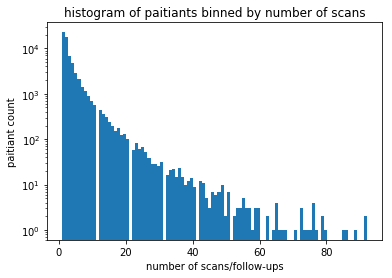

In [312]:
cheXpert['id'].value_counts().hist(bins=100, grid=False)
plt.yscale('log')
plt.title('histogram of paitiants binned by number of scans')
plt.xlabel('number of scans/follow-ups')
plt.ylabel('paitiant count')

Text(0.5,1,'num of labels hist')

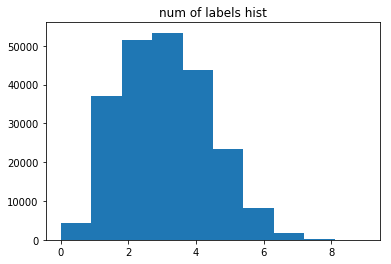

In [100]:
cheXpert[cheXpert.columns[5:]].abs().sum(axis=1).hist(grid=False, bins=10)
plt.title('num of labels hist')

Text(0.5,1,'CheXpert conditions over scan type')

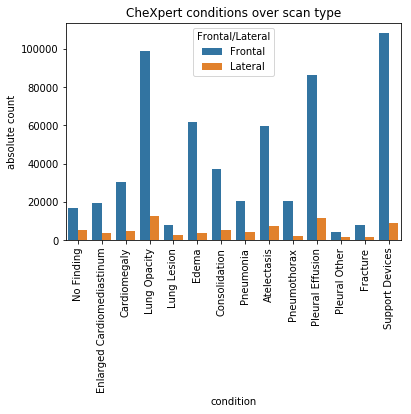

In [280]:
fig = sns.barplot(x='level_1', y=0, hue='Frontal/Lateral', data=pd.DataFrame(target_table.T.unstack()).reset_index())
fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
plt.ylabel('absolute count')
plt.xlabel('condition')
plt.title('CheXpert conditions over scan type')

Text(0.5,1,'CheXpert conditions over scan type (ratio from font/back)')

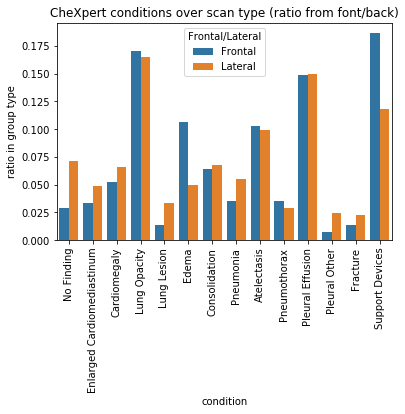

In [316]:
normalized = (target_table.T / target_table.sum(axis=1)).T
fig = sns.barplot(x='level_1', y=0, hue='Frontal/Lateral', data=pd.DataFrame(normalized.T.unstack()).reset_index())
fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
plt.ylabel('ratio in group type')
plt.xlabel('condition')
plt.title('CheXpert conditions over scan type (ratio from font/back)')

Text(0.5,1,'CheXpert conditions over scan type (ratio by condition)')

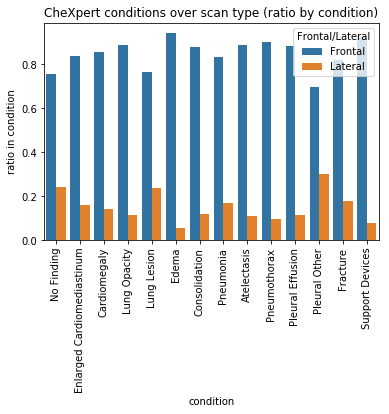

In [318]:
normalized = (target_table / target_table.sum(axis=0))
fig = sns.barplot(x='level_1', y=0, hue='Frontal/Lateral', data=pd.DataFrame(normalized.T.unstack()).reset_index())
fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
plt.ylabel('ratio in condition')
plt.xlabel('condition')
plt.title('CheXpert conditions over scan type (ratio by condition)')

In [102]:
# label questions
Parenchymal = [ # i.e. findings in the lungs themselves
'Lung Lesion',
'Lung Opacity',
'Edema',
'Consolidation',
'Pneumonia',
'Atelectasis',
]

Extraparenchymal = [ # i.e. findings outside the lungs
'Support Devices',
'Pleural Effusion',
'Pleural Other',
'Pneumothorax',
'Cardiomegaly',
'Enlarged Cardiomediastinum',
'Fracture',
]

In [109]:
cheXpert[Parenchymal].fillna(0).abs().groupby('Lung Opacity').sum()

,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis
Lung Opacity,,,,,
0.0,4226.0,27394.0,16542.0,4749.0,25523.0
1.0,6449.0,37881.0,26016.0,20068.0,41672.0


## morph calibration

In [6]:
image_path = 'data/morph_example/00024_og.jpg'

In [12]:
source = Image.open(image_path)

In [20]:
from Datasets import ImageNet_norm
import cv2
pre = trans.Compose([
        trans.RandomResizedCrop(224, scale=(1, 1)),
        trans.RandomHorizontalFlip(),
        trans.ToTensor(),
        #ImageNet_norm,
])


In [22]:
res_tensor = cv2.blur(pre(source).cpu().data.numpy()[0], (17, 17))

In [26]:
dst_im = (res_tensor[None, :].transpose(1, 2, 0) * 255).astype(np.uint8)

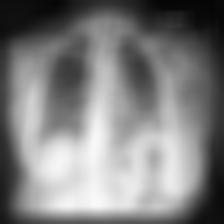

In [47]:
trans.ToPILImage()(dst_im)

# mimic

mimic is problematic. use and account and follow the commands below

In [58]:
sample_path = 'data/MIMIC/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p11/p11413236/s52541396/'
sample_a = sample_path+'35a29873-f440b817-77e9b07e-ebd31997-8c62d96e.jpg'
sample_b = sample_path+'46bdab14-1fa0233c-c0b0841d-4c0869de-6564ff0d.jpg'

In [112]:
import tqdm
from PIL import Image
import subprocess

In [111]:
resize_func(im).save

<bound method Image.save of <PIL.Image.Image image mode=L size=1201x1000 at 0x7F1EB1D69668>>

In [66]:
ftp_path = 'https://physionet.org/files/mimic-cxr-jpg/2.0.0/'
im_dirs = ['files/p'+str(10+x) for x in range(10)]
other_files= [
    'SHA256SUMS.txt'
    'mimic-cxr-2.0.0-chexpert.csv.gz'
    'mimic-cxr-2.0.0-metadata.csv.gz'
    'mimic-cxr-2.0.0-negbio.csv.gz'
    'mimic-cxr-2.0.0-split.csv.gz'
]
command = 'wget -r -N -R html,tmp --convert-links -c -np --user paulyi88 --password j1gg@012'

In [113]:
counter = 0
for curr_dir, dirs_in_curr_dir, files in os.walk('data/MIMIC/physionet.org/files/mimic-cxr-jpg/2.0.0/files/'):
    for file in files:
        if '.jpg' in file:
            counter += 1

In [ ]:
root = 'data/MIMIC/physionet.org/files/mimic-cxr-jpg/2.0.0/'
def resize_dir(root, target_size=1024):
    bar = tqdm.tqdm_notebook(total=counter)
    for curr_dir, dirs_in_curr_dir, files in os.walk(root):
        for file in files:
            if '.jpg' in file:
                im = Image.open(os.path.join(curr_dir, file))
                resize_func = trans.Resize(min(target_size, max(im.size)))
                resize_func(im).save(os.path.join(curr_dir, file))
                bar.update(1)

In [ ]:
# download metadata
for file for other_files:
    subprocess.call(command + ' ' + ftp_path+file, shell=True)

In [77]:
# download images
for im_dir for im_dirs:
    subprocess.call(command + ' ' + ftp_path+imdir, shell=True)
    print(im_dir)
    resize_dir(root+imdir)

('data/MIMIC/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p11/p11413236/s52541396/',
 [],
 ['35a29873-f440b817-77e9b07e-ebd31997-8c62d96e.jpg',
  '46bdab14-1fa0233c-c0b0841d-4c0869de-6564ff0d.jpg'])